In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime

In [35]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [36]:
to_drop=["outside_diameter","wall_thickness","raised_face_depth","w_neck_c", "flange_outer_radius", "flange_thickness_d",
        "raised_face_radius", "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
data.drop(columns=to_drop,inplace=True)

In [37]:
data.dtypes

pipe_dn                     int64
pipe_schedule              object
flange_class                int64
length1                   float64
length2                   float64
lumped_mass               float64
frequency                 float64
x_deformation_position    float64
y_deformation_position    float64
z_deformation_position    float64
support                    object
allowable_deformation     float64
dtype: object

In [38]:
numeric_features = ['pipe_dn','flange_class', 'length1', 'length2', 'lumped_mass',
                    ]
categorical_features = ['pipe_schedule', 'support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [39]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [40]:
target_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(target_columns, axis=1)
y = data[target_columns]

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [42]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [43]:
scaler_y = StandardScaler()
y_train_transformed = scaler_y.fit_transform(y_train)
y_test_transformed = scaler_y.transform(y_test)

In [44]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [45]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 16784), started 1 day, 19:20:04 ago. (Use '!kill 16784' to kill it.)

In [46]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(16, activation='relu')(dropout2)

# Separate output for each target variable
output_allowable_deformation = Dense(1, name='allowable_deformation')(hidden3)
output_frequency = Dense(1, name='frequency')(hidden3)
output_x_position = Dense(1, name='x_deformation_position')(hidden3)
output_y_position = Dense(1, name='y_deformation_position')(hidden3)
output_z_position = Dense(1, name='z_deformation_position')(hidden3)

In [47]:
model = Model(inputs=input_layer, outputs=[output_allowable_deformation, output_frequency, 
                                           output_x_position, output_y_position, output_z_position])

In [48]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              loss_weights=[1.0, 1.0, 1.0, 1.0, 1.0],
              )

In [49]:
history = model.fit(
    x_train_transformed, 
    [y_train_transformed[:, i] for i in range(5)],  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - allowable_deformation_loss: 0.9543 - frequency_loss: 1.0031 - loss: 4.9659 - x_deformation_position_loss: 0.8866 - y_deformation_position_loss: 1.0853 - z_deformation_position_loss: 1.0365 - val_allowable_deformation_loss: 0.4523 - val_frequency_loss: 0.4894 - val_loss: 2.7507 - val_x_deformation_position_loss: 0.2139 - val_y_deformation_position_loss: 0.6445 - val_z_deformation_position_loss: 0.9233
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - allowable_deformation_loss: 0.5517 - frequency_loss: 0.5505 - loss: 3.0913 - x_deformation_position_loss: 0.3113 - y_deformation_position_loss: 0.7410 - z_deformation_position_loss: 0.9369 - val_allowable_deformation_loss: 0.1956 - val_frequency_loss: 0.2511 - val_loss: 2.0271 - val_x_deformation_position_loss: 0.1101 - val_y_deformation_position_loss: 0.5672 - val_z_deformation_position_loss: 0.8735
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - allowable_deformation_loss:

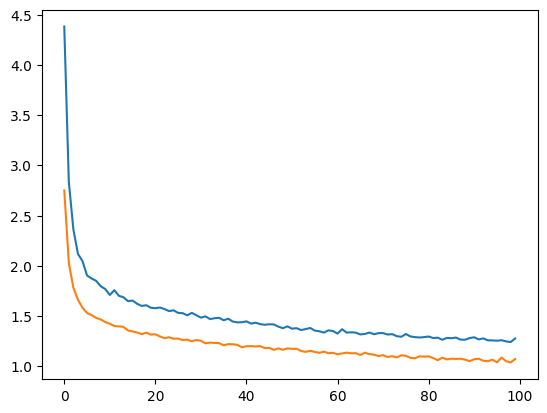

In [58]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [51]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y.inverse_transform(np.column_stack(predictions_scaled))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [52]:
predictions_df = pd.DataFrame(predictions, columns=target_columns)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
   allowable_deformation  frequency  x_deformation_position  \
0              29.529079   8.401576            -2851.011719   
1               5.429661  53.995346             -248.721359   
2              26.358120   9.864469            -2380.495117   
3              -1.301575   8.822181             -127.751762   
4               5.744013  11.703690             -872.630798   

   y_deformation_position  z_deformation_position  
0               39.580467               -2.577403  
1               -1.248113              -16.079273  
2               42.400230               -3.054086  
3               -5.224140             -151.344910  
4                4.557723               16.078482  


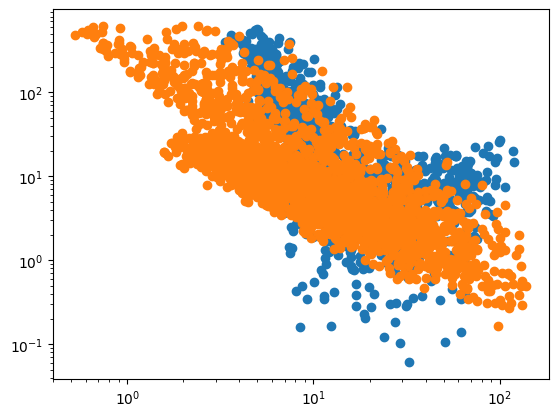

In [53]:
x=predictions_df["frequency"]
y=predictions_df["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
x=y_test["frequency"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
plt.show()

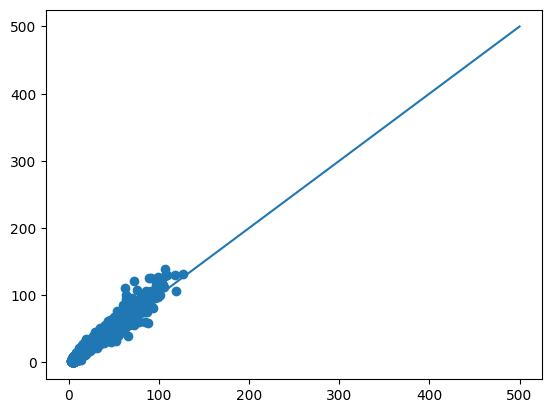

In [54]:
x=predictions_df["frequency"]
y=y_test["frequency"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 500],[0, 500])
plt.show()

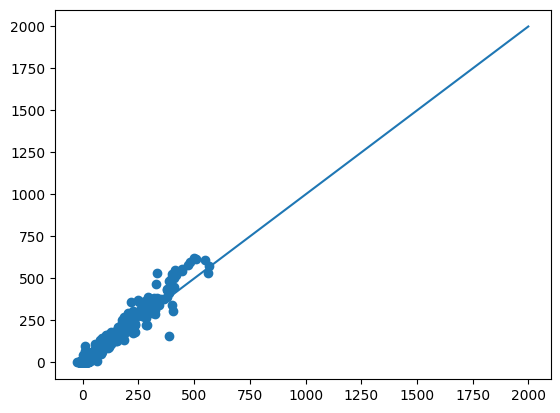

In [55]:
x=predictions_df["allowable_deformation"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 2000],[0, 2000])
plt.show()

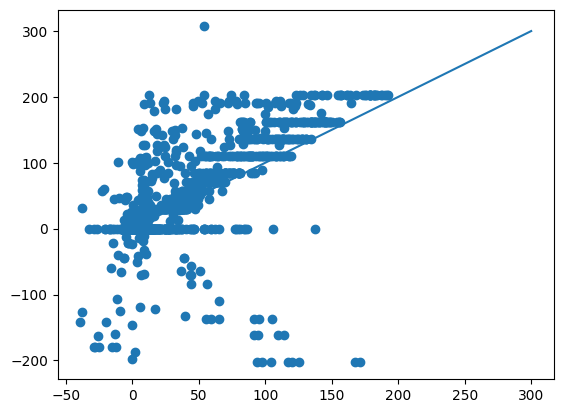

In [56]:

x=predictions_df["y_deformation_position"]
y=y_test["y_deformation_position"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 300],[0, 300])
plt.show()

(array([  1.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   2.,   0.,   1.,
          3.,   1.,   1.,   3.,   0.,   2.,   9.,   2.,   3.,   2.,  12.,
         20.,  22., 280., 128.,   9.,   1.,   1.,   1.]),
 array([-498.46186987, -478.47074732, -458.47962476, -438.4885022 ,
        -418.49737965, -398.50625709, -378.51513453, -358.52401198,
        -338.53288942, -318.54176686, -298.55064431, -278.55952175,
        -258.56839919, -238.57727664, -218.58615408, -198.59503152,
        -178.60390897, -158.61278641, -138.62166385, -118.6305413 ,
         -98.63941874,  -78.64829619,  -58.65717363,  -38.66605107,
         -18.67492852,    1.31619404,   21.3073166 ,   41.29843915,
          61.28956171,   81.28068427,  101.27180682]),
 <BarContainer object of 30 artists>)

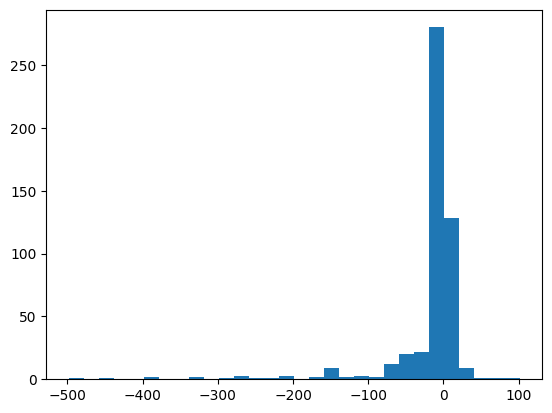

In [57]:
error= y_test["allowable_deformation"]-predictions_df["allowable_deformation"]
plt.hist(error,bins=30)